In [21]:
#import libraries
import os as os
os.environ['USE_PYGEOS'] = '0'
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
import networkx as nx
import shapely as shply
import folium as fm
import rasterio as rio
import elevation as elev

In [22]:
#evacuation zone shape files
xl_ev_zones = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/Statewide_Tsunami_Scenarios/Statewide_XL_Tsunami_Inundation_Scenario.shp')
xxl_ev_zones = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/Statewide_Tsunami_Scenarios/Statewide_XXL_Tsunami_Inundation_Scenario.shp')

#critical facilities shape file
critical_facil = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/final_project/EvacuationBrochure_Data/CriticalFacilities.shp')
#reprojecting
critical_facil = critical_facil.to_crs('EPSG:4326')


In [23]:
#reprojecting ev zones
xxl_ev_zones = xxl_ev_zones.to_crs('EPSG:4326')
xl_ev_zones = xl_ev_zones.to_crs('EPSG:4326')

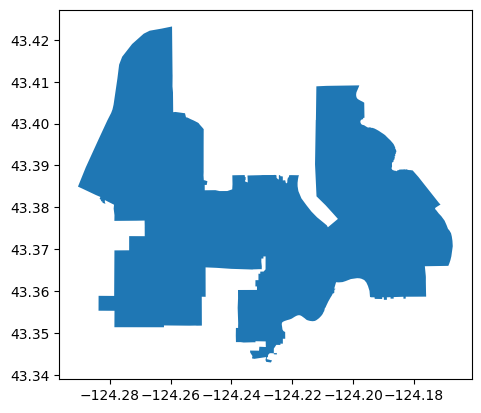

In [24]:
ox.settings.log_console=True
# define the place query for coos bay on osmnx
query = {'city': 'Coos Bay'}

# get the boundaries of the city limits
gdf_coos = ox.geocode_to_gdf(query)
gdf_coos.plot()

coos_bay = gdf_coos.envelope
coos_bay = coos_bay.scale(2,4,2)

In [25]:
coos_bay
coos_bay = coos_bay.to_crs('EPSG:4326')

In [26]:
#checking coos bay data
gdf_coos.head()

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-124.29044 43.38495, -124.28897 43.3...",43.42319,43.342956,-124.167292,-124.290437,298362632,relation,186285,43.367894,-124.217465,"Coos Bay, Coos County, Oregon, 97420, United S...",boundary,administrative,0.656381


In [27]:
#getting coos bay building data
tags = {'building': True}
cb_buildings = ox.geometries_from_place('Coos Bay, Oregon, USA', tags)


/Users/maxspiegel/.gds/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

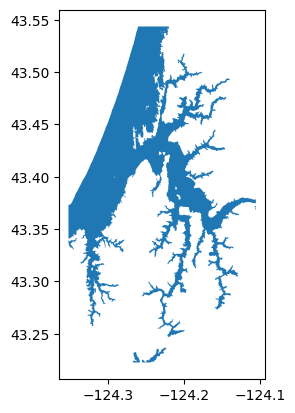

In [29]:
#clipping evacuation zones to coos bay area)
#xxl
clipped_ev_xxl = xxl_ev_zones.clip(coos_bay)

#xl
clipped_ev_xl = xl_ev_zones.clip(coos_bay)

clipped_ev_xl.plot()

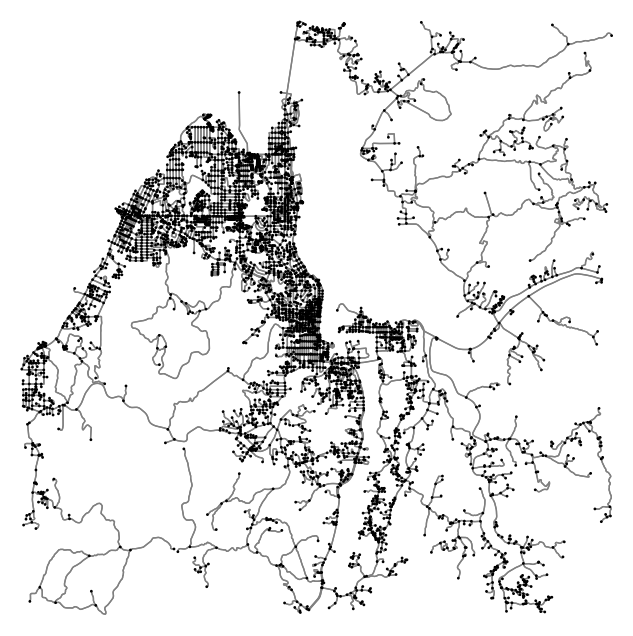

In [31]:
#creating coos bay network
lat_lon = (43.3672, -124.2131)
coos_ntwrk = ox.graph_from_point(lat_lon, dist=8000, network_type='walk')
fig, ax = ox.plot_graph(coos_ntwrk, bgcolor='white', node_color='black', edge_color='grey', node_size=4)

node_graph = ox.graph_to_gdfs(coos_ntwrk, nodes=True, edges=False)
edge_graph = ox.graph_to_gdfs(coos_ntwrk, nodes=False, edges=True)
node_clip = node_graph.clip(gdf_coos)


<AxesSubplot: >

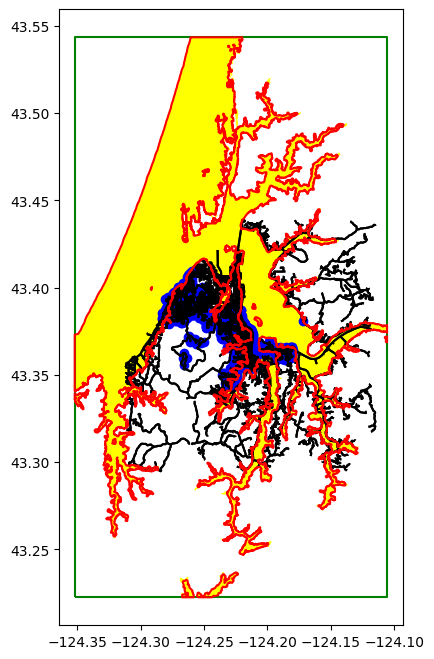

In [38]:
#graphing the network with the evacuation zones, and coos bay city limits
fig, ax = plt.subplots(figsize=(12, 8))
clipped_ev_xxl.plot(ax=ax, color= "yellow")
node_clip.plot(ax=ax, color= "blue")
edge_graph.plot(ax=ax, color="black")
coos_bay.boundary.plot(ax=ax, color="green")
clipped_ev_xl.boundary.plot(ax=ax, color = 'red')

In [33]:
#assembly areas and higher ground shape files + reproject
assembly_areas =gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/Assembly_Areas.shp')
assembly_areas= assembly_areas.to_crs('EPSG:4326')

higher_ground = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/OutsideHazardArea_GreenHighGround.shp')
higher_ground= higher_ground.to_crs('EPSG:4326')

In [34]:
#clipping critical facil to coos bay area
crit_clip = critical_facil.clip(coos_bay)
crit_clip

,Id,Site_Type,Name,POINT_X,POINT_Y,geometry
571,0,BRIDGE,Hwy 35 over COR,-124.225056,43.245731,POINT (-124.22507 43.24574)
594,0,BRIDGE,"Noble Creek, County Rd 118G",-124.213559,43.252592,POINT (-124.21357 43.25260)
516,0,FIRE DEPARTMENT,Greenacres RFPD,-124.207093,43.255130,POINT (-124.20711 43.25514)
535,0,SCHOOL,Green Acres School,-124.208112,43.255727,POINT (-124.20813 43.25573)
618,0,BRIDGE,"Manning Gulch Slough, Hwy 35",-124.225295,43.259356,POINT (-124.22531 43.25936)
...,...,...,...,...,...,...
600,0,BRIDGE,"North Slough, County Rd 15",-124.194683,43.498787,POINT (-124.19470 43.49879)
498,0,SCHOOL,North Bay Light House Elementary School,-124.210909,43.501533,POINT (-124.21092 43.50154)
517,0,FIRE DEPARTMENT,Hauser RFPD,-124.213146,43.501795,POINT (-124.21316 43.50180)
630,0,BRIDGE,"Saunders Lake, County Rd 220A",-124.219858,43.530090,POINT (-124.21987 43.53010)


<AxesSubplot: >

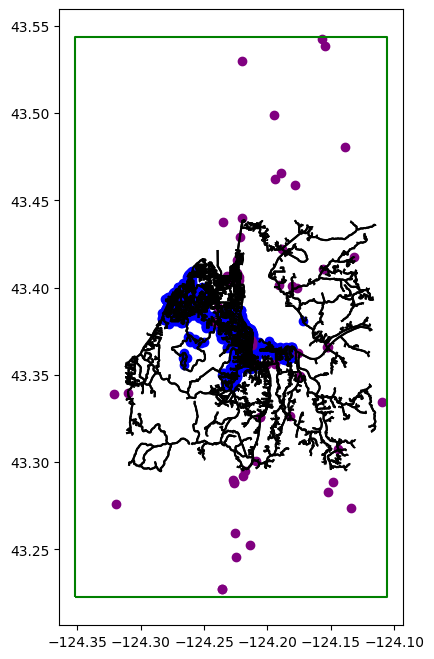

In [35]:
#filtering out for just the bridges, plotting 
bridge_crit = crit_clip[crit_clip['Site_Type'] == 'BRIDGE']

fig, ax = plt.subplots(figsize=(12, 8))

node_clip.plot(ax=ax, color= "blue")
edge_graph.plot(ax=ax, color="black")
coos_bay.boundary.plot(ax=ax, color="green")

bridge_crit.plot(ax=ax, color= 'purple')
